In [9]:
import warnings
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import re
from kiwipiepy import Kiwi
from sqlalchemy import create_engine

from wordcloud import WordCloud
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
warnings.filterwarnings('ignore')

# Text data Analysis

## Text processing

### 토큰화 (Tokenization)

주어진 코퍼스 내에서 분석 대상이 되는 유의한 단위인 토큰으로 나누는 작업<br>
<br>
ex) I like chicken <br>
-> token: I, like, chicken<br>

- token (토큰): 텍스트를 분석하기 위해 나누는 가장 작은 단위
- corpus(코퍼스): 자연어 처리와 언어학에서 언어 분석을 위해 컴퓨터에 저장된 대규모의 체계적 자연어 자료 모음
- 단순히 특수문자 등을 제외하고 공백 기준으로 잘라내는 작업이라고 할 수 없다<br>
<br>
> ex) 줄임말, 야민정음, 기타, 36.5, Ph.D, ...

### 정제 (Cleaning)

가지고 있는 단어 집합에서 불필요한 데이터를 제거<br>
토큰화 작성 전후로 적용<br>
<br>
> ex) 등장 빈도가 적은 단어, 길이가 짧은 단어, ...

### 정규화 (Normalization)

표현방법이 다른 단어를 하나의 단어로 통합<br>
<br>
> ex)
- 대소문자 (APPLE == apple) <br>
- 어간 / 표제어 (running, ran, runs -> run)<br>
- 동의어 (USA == US)

### 표제어 추출 (Lemmatization)

단어의 어근을 찾아 추출<br>
<br>
> ex) <br>
- am, are, is -> be
- went -> go

### 불용어 (Stopword)

가지고 있는 데이터 중 불필요한 토큰을 제거 <br>
자주 등장하지만 분석에 큰 도움이 되지 않는 단어<br>
<br>
> ex) am, I and, about

--------------

## WordCloud

데이터의 태그들을 분석하여 중요도나 인기도 등을 고려하여 시각적으로 표시 <br>
-> 텍스트의 데이터를 시각화하여 단어의 빈도나 중요성을 직관적으로 보여주는 도구

## Kiwi 객체

한국어 형태소 분석을 위한 도구로, _kiwiepy_ 라는 라이브러리에서 제공하는 클래스 <br>
형태소 분석, 문장 분리, 띄어쓰기 교정 등의 작업 수행 가능 <br>
-> 텍스트를 보다 구조적으로 분석하고 처리 가능 <br>
- 형태소 분석: 텍스트를 형태로 단위로 분리 <br>
-> 형태소의 품사 정보 제공
- 사용자 사전 추가: 사용자 정의 단어를 사전에 추가하여 분석에 반영 가능
- 문장 복원 및 교정: 형태소를 결합하여 문장을 복원하거나 띄어쓰기 교정 가능 <br>
-> 주로 텍스트 전처리 과정에서 사용됨

In [10]:
# Kiwi 객체를 생성
kiwi = Kiwi()

# 'kiwi_tokenizer' function
# 'contents': 입력 텍스트, 'Stopwords': 불용어 목록 (optional)
def kiwi_tokenizer(contents, stopwords=None):

    # 'contents'를 Kiwi 객체로 tokenize(단어 분리)하고, 명사(NNP, NNG)만 추출
    tokens = [
        token.form                                          # 각 token의 형태소 반환 (단어 자체)
        for token
        in kiwi.tokenize(contents, stopwords=stopwords)     # Kiwi 객체로 tokenize 실행
        if token.tag in {'NNP', 'NNG'}                      # 추출된 token이 NNP(고유명사) 혹은 NNG(일반명사)일 경우만 핉터링
    ]

    # 최종적으로 명사들로만 구성된 리스트 반환
    return tokens

## Practice 

#### 유튜브 댓글 분석

In [29]:
comments = pd.read_csv('./data/NLP/comments.csv').query('video_id == "JPaubSOSxeM"')

In [30]:
comments['tokens'] = comments.comments.apply(lambda x: kiwi_tokenizer(x))
comments

,video_id,comments,tokens
0,JPaubSOSxeM,와 ㅋㅋㅋ ㄹㅇ 숨막힌다 ㅋㅋㅋ,[숨]
1,JPaubSOSxeM,아빠가 세뇌 당함..... ㅋㅋㅋㅋㅋㅋㅋ,"[아빠, 세뇌]"
2,JPaubSOSxeM,아 존나 웃기닼ㅋㅋㅋㅋㅋㅋㅋ,[]
3,JPaubSOSxeM,여자들아 남자 믿지 말고 외박하지마라..,"[여자, 남자, 외박]"
4,JPaubSOSxeM,"이건 사랑이 아니다. 애비를 죽여라,","[사랑, 애비]"
...,...,...,...
3848,JPaubSOSxeM,오우,[]
3849,JPaubSOSxeM,1등 ^^,[]
3850,JPaubSOSxeM,와!,[]
3851,JPaubSOSxeM,재밌네요,[]


In [39]:
# 빈 dictopnary vocabs를 생성하여 단어와 빈도 저장
vocabs = {}

# comments dataframe의 tokens 열을 list로 변환하고, 모든 토큰을 하나의 튜플로 결합
words = tuple(itertools.chain(*comments.tokens.tolist()))

# 각 단어의 빈도 계산
for word in words:
    # 단어가 이미 vocabs에 존재하는 경우 빈도 +1
    if word in vocabs:
        vocabs[word] += 1
    # 단어가 vocabs에 없는 경우 새로 추가하고 빈도 1로 설정
    else:
        vocabs[word] = 1

# 최종적으로 단어와 빈도 저장한 dictionary vocabs 반환
vocabs

{'숨': 113,
 '아빠': 196,
 '세뇌': 2,
 '여자': 24,
 '남자': 34,
 '외박': 37,
 '사랑': 12,
 '애비': 3,
 '아영': 63,
 '짧대': 5,
 '아버지': 81,
 '귀여워': 1,
 '이번': 101,
 '레전드': 48,
 '좀비': 2,
 '소리': 16,
 '수정': 87,
 '대역': 2,
 '대박': 23,
 '이야기': 9,
 '기업': 2,
 '딸아이': 4,
 '캐나다': 2,
 '의심': 15,
 '엄마': 62,
 '마누라': 4,
 '장모': 1,
 '장인': 1,
 '구라': 13,
 '일': 22,
 '상기': 1,
 '딸': 154,
 '관광': 7,
 '진전': 1,
 '유투브': 5,
 '확인': 6,
 '사위': 1,
 '사이': 8,
 '손주': 2,
 '지금': 13,
 '사실': 2,
 '타임': 1,
 '결국': 5,
 '할아버지': 3,
 '장려': 1,
 '아버님': 56,
 '선': 6,
 '대본': 29,
 '야채': 66,
 '누나': 10,
 '뷰티 인사이드': 3,
 '죈장': 1,
 '눈물': 8,
 '돈': 8,
 '나이': 21,
 '세상': 20,
 '평생': 6,
 '양육': 1,
 '여행': 12,
 '시집': 9,
 '신데렐라': 1,
 '놀이': 1,
 '때': 122,
 '먹버': 1,
 '남친': 29,
 '호흡': 7,
 '아내': 6,
 '짓': 4,
 '딸래미': 4,
 '펜션': 10,
 '말': 38,
 '스릴러': 19,
 '본인': 2,
 '자연': 7,
 '사람': 37,
 '아귀': 1,
 '연기': 99,
 '나라': 3,
 '평균': 1,
 '외모': 6,
 '고봉': 1,
 '중간': 11,
 '몰입': 33,
 '급발진': 10,
 '모습': 7,
 '인간': 3,
 '골프채': 2,
 '낙': 4,
 '시대': 5,
 '낚시': 79,
 '생각': 34,
 '반추': 1,
 '물': 8,
 '뒤': 56,
 '지리'

In [40]:
# vocabs의 단어(key)를 빈도에 따라 내림차순 정렬
# 각 단어를 정렬된 순서에 맞춰 빈도를 mapping하여 새로운 dictionary 생성
dict(zip(
    sorted(vocabs, key=lambda x: vocabs[x], reverse = True),    # vocabs의 key를 빈도에 따라 내림차순 정렬
    sorted(vocabs.values(), reverse = True)                     # vocabs의 값을 내림차순 정렬  
))

{'축하': 266,
 '영상': 254,
 '아빠': 196,
 '딸': 154,
 '이세돌': 145,
 '때': 122,
 '개': 119,
 '숨': 113,
 '알파고': 109,
 '수': 105,
 '이번': 101,
 '연기': 99,
 '수정': 87,
 '신': 82,
 '아버지': 81,
 '낚시': 79,
 '구독자': 72,
 '최고': 67,
 '야채': 66,
 '아영': 63,
 '엄마': 62,
 '마지막': 61,
 '바둑': 60,
 '아버님': 56,
 '뒤': 56,
 '퀄리티': 56,
 '부모': 54,
 '디테일': 52,
 '잼': 50,
 '친구': 49,
 '진짜': 49,
 '국': 49,
 '레전드': 48,
 '너덜트': 48,
 '급': 47,
 '반전': 46,
 '전': 45,
 '부녀': 44,
 '신뢰': 42,
 '역대': 40,
 '말': 38,
 '채널': 38,
 '외박': 37,
 '사람': 37,
 '대': 36,
 '수정이': 36,
 '박': 36,
 '구독': 35,
 '창': 35,
 '남자': 34,
 '생각': 34,
 '시간': 34,
 '몰입': 33,
 '감사': 33,
 '전화': 33,
 '공감': 33,
 '집': 33,
 '소파': 30,
 '배우': 30,
 '영화': 30,
 '대본': 29,
 '남친': 29,
 '통화': 29,
 '티키타카': 27,
 '대국': 27,
 '정도': 26,
 '숏': 26,
 '오늘': 26,
 '방패': 25,
 '역': 25,
 '앞': 25,
 '중요': 25,
 '여자': 24,
 '박스': 24,
 '대박': 23,
 '대사': 23,
 '지간': 23,
 '딜': 23,
 '일': 22,
 '이름': 22,
 '자식': 22,
 '결혼': 22,
 '낚싯대': 22,
 '어머니': 22,
 '나이': 21,
 '기대': 21,
 '현실': 21,
 '세상': 20,
 '댓글': 20,
 '기보': 20,
 '스릴러

In [51]:
words = np.array(words)
words = np.where((words == '아버지') | (words == '아버님'), '아빠', words)
words = np.where(words == '수정', '수정이', words)

In [54]:
counter = Counter(words)

In [55]:
counter.pop('때')
counter.pop('수')
counter.pop('신')
counter.pop('뒤')
counter.pop('개')
counter.pop('숨')
counter.pop('역')

25

In [56]:
counter.pop('축하')
counter.pop('영상')
counter.pop('이번')
counter.pop('정도')

26

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

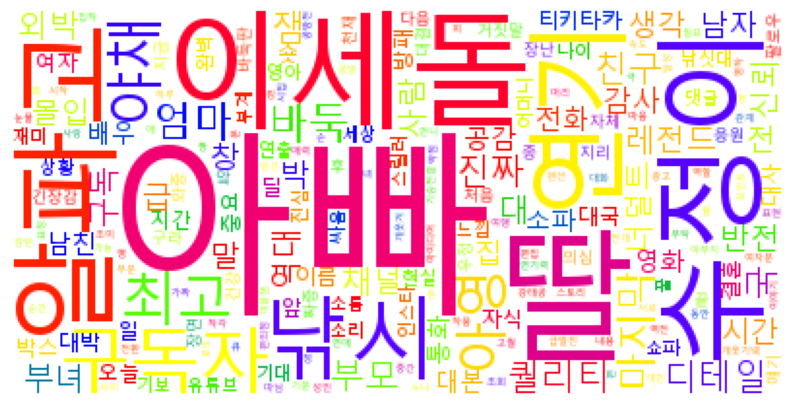

In [58]:
word_cloud = WordCloud(
    font_path = 'malgun',
    background_color = 'white',
    max_font_size = 100,
    colormap = 'prism',
).generate_from_frequencies(counter)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis('off')

#### 유튜브 댓글 분석 - 곽튜브

In [80]:
kwak = pd.read_pickle('./data/NLP/comments_kwak.pickle')
kwak

,channelId,videoId,parentID,textDisplay,textOriginal,authorDisplayName,likeCount,publishedAt,updatedAt,parentId
0,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,,곽튜브 힘내시라! 항상 응원할게~,곽튜브 힘내시라! 항상 응원할게~,@junobox7004,1,2024-10-04T01:20:38Z,2024-10-04T01:20:38Z,NaN
1,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,,동싱아 잘있나?,동싱아 잘있나?,@user-rz7mn4gx2c,4,2024-10-04T00:23:53Z,2024-10-04T00:23:53Z,NaN
2,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,,형 돌아와요!!!,형 돌아와요!!!,@무징징이,5,2024-10-04T00:09:08Z,2024-10-04T00:09:08Z,NaN
3,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,,언제 새 동영상 볼수있는거임. 기다리고있음. 항상 응원. 그럴 사람 아니란거 아니까,언제 새 동영상 볼수있는거임. 기다리고있음. 항상 응원. 그럴 사람 아니란거 아니까,@usangjung7865,4,2024-10-04T00:07:30Z,2024-10-04T00:07:30Z,NaN
4,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,,아니 이쁘면 무죈데 왤캐 선비들이 많음?,아니 이쁘면 무죈데 왤캐 선비들이 많음?,@1a2a3a4a5aa,2,2024-10-03T23:42:27Z,2024-10-03T23:42:27Z,NaN
...,...,...,...,...,...,...,...,...,...,...
5100,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,NaN,@@trumpdonald6781질투하누 ㅋㅎㅋㅎㅋㅎ,@@trumpdonald6781질투하누 ㅋㅎㅋㅎㅋㅎ,@Yoon____90,12,2024-08-30T12:24:10Z,2024-08-30T12:24:10Z,Ugx-p0gVXHlBTszw53x4AaABAg
5101,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,NaN,ㅐ,ㅐ,@user-xn6id7pp4s,0,2024-08-30T12:53:06Z,2024-08-30T12:53:06Z,Ugx-p0gVXHlBTszw53x4AaABAg
5102,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,NaN,축하해요... 덕포동의 자랑!! 곽튜브,축하해요... 덕포동의 자랑!! 곽튜브,@포장의마법,3,2024-08-30T12:13:53Z,2024-08-30T12:13:53Z,UgynyiSumZLL457W9eJ4AaABAg
5103,UClRNDVO8093rmRTtLe4GEPw,1IlOwJtyE7Q,NaN,"<a href=""https://www.youtube.com/watch?v=1IlOw...",14:00 딱봐도 불편해하는데 사장이라 뭔 말도 못하겠고 직원들이 밑이네 확실히ㅋㅋ,@trumpdonald6781,0,2024-08-30T12:23:48Z,2024-08-30T12:23:48Z,Ugwf8kyQ4HNz4t5CVEB4AaABAg


In [79]:
# Kiwi 객체를 생성
kiwi = Kiwi()

# 'kiwi_tokenizer' function
# 'contents': 입력 텍스트, 'Stopwords': 불용어 목록 (optional)
def kiwi_tokenizer(contents, stopwords=None):

    # 'contents'를 Kiwi 객체로 tokenize(단어 분리)하고, 명사(NNP, NNG)만 추출
    tokens = [
        token.form                                          # 각 token의 형태소 반환 (단어 자체)
        for token
        in kiwi.tokenize(contents, stopwords=stopwords)     # Kiwi 객체로 tokenize 실행
        if token.tag in {'NNP', 'NNG'}                      # 추출된 token이 NNP(고유명사) 혹은 NNG(일반명사)일 경우만 핉터링
    ]

    # 최종적으로 명사들로만 구성된 리스트 반환
    return tokens

In [87]:
kiwi = Kiwi()
kiwi.add_user_word('곽튜브', 'NNP')
kiwi.add_user_word('학폭', 'NNG's\)
kiwi.add_user_word('곽튜브', 'NNP')

In [ ]:
stopwords = Stopwords()
stopwords

In [ ]:
kwak['tokens'] = kwak.textOriginal.apply(lambda x: kiwi_tokenizer(x))
counter = Counter(list(itertools.chain(*kwak.tokens)))

In [89]:
counter.pop('노무현')
counter.pop('컴퍼니')

263

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

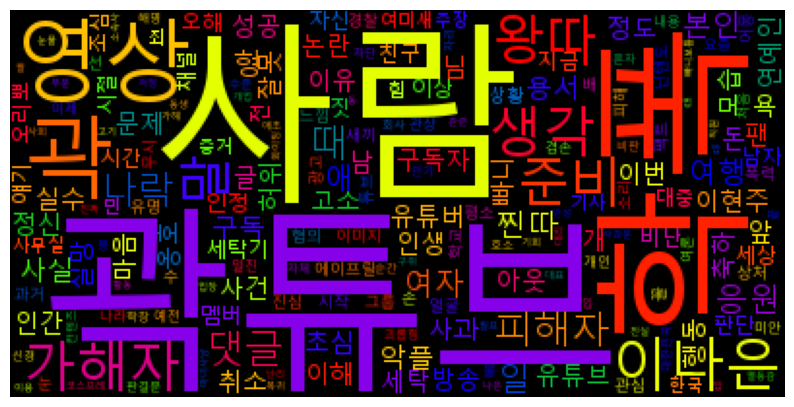

In [90]:
word_cloud = WordCloud(
    font_path='malgun',
    background_color='black',
    max_font_size=100,
    colormap='prism',
).generate_from_frequencies(counter)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis('off')